# Making bets on NBA games using Bayesian Neural Networks
The goal of this notebook is to explore the use of BNNs in predicting the outcome of NBA games. While using MLPs as seen in ```mlp_betting.ipynb``` may be computationally more efficient, personal testing has shown that tradional neural networks are overconfident in predictions making them unsuitable for betting. By learning the distributions of weights, BNNs can hopefully provide a better estimate on the outcome of games for use in betting.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV,cross_validate,cross_val_predict
from sklearn.metrics import classification_report,confusion_matrix,make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from util.client import Nba_Season
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.nn import PyroModule, PyroSample
import torch
import torch.nn as nn
from torch.nn import Softmax
from pyro.infer import MCMC, NUTS
from pyro.infer import Predictive

## Define simple BNN using Pyro containing 1 hidden layer

For this implementation, we will be using the [Pyro Probablistic Programming language](https://github.com/pyro-ppl/pyro), loosely following a [tutorial](https://colab.research.google.com/drive/1NQNMdKaE9RncuWgO_vM2k3qywV76Byfh) from the University of Amsterdam

Currently, the model will only be predicting the outcomes of games (home win or away win) and compare outcomes to moneyline odds from [vegas insider](https://www.vegasinsider.com/nba/odds/las-vegas/). Because of this, the model will be learning a categorical output, 0 indicating a home win and 1 indicating away win. The model will sample each layers weights and biases from a normal distribution while the prediction will be sampled from a categorical distribution based on the output of the layers.

In [2]:
class BNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=5, prior_scale=1.):
        super().__init__()

        self.activation = nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([in_dim, hid_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim,]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, out_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim,]).to_event(1)) # output bias term

    def forward(self, x, y=None):
        z1 = self.activation(x @ self.layer1.weight + self.layer1.bias) # pass thru first layer
        z2 = self.activation(z1 @ self.layer2.weight + self.layer2.bias) # pass thru output layer

        #, x.shape[0]
        with pyro.plate("data"):
            y_hat = Softmax(dim=1)(z2) # scale output via softmax for setting categorical priors
            # y_hat = Softmax(dim=0)(x)
            obs = pyro.sample("obs", dist.Categorical(y_hat), obs=y)

        return z2

In [7]:
# load old samples and features
features = np.genfromtxt('../NBA/total/samps_feats/2015-2023_nba_features_norm_inj.csv',delimiter=',')
samples = np.genfromtxt('../NBA/total/samps_feats/2015-2023_nba_samples_inj.csv',delimiter=',')
samples_1d = [0 if j[0] == 0 else 1 for j in samples]
feat_train, feat_test, samp_train, samp_test = train_test_split(features, samples, test_size=0.25, random_state=1)
x_train = torch.FloatTensor(feat_train)
x_test = torch.FloatTensor(feat_test)
y_train = torch.FloatTensor(samp_train)
y_test = torch.FloatTensor(samp_test)

In [66]:
from pyro.infer import MCMC, NUTS

model = BNN(in_dim=16,hid_dim=16,out_dim=2)

pyro.set_rng_seed(1)

# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(model, jit_compile=False)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get 50 posterior samples
mcmc = MCMC(nuts_kernel, num_samples=50)

mcmc.run(x_train, y_train.T)

Warmup:   0%|          | 0/100 [00:00, ?it/s]

Sample: 100%|██████████| 100/100 [07:31,  4.51s/it, step size=1.17e-02, acc. prob=0.450]


In [81]:
from pyro.infer import Predictive

# get predictions based on posteriors
predictive = Predictive(model=model, posterior_samples=mcmc.get_samples(), return_sites=['obs','_RETURN'])

train_preds = predictive(x_train)['obs'].T.float().mean(axis=1) # each x in training produces 50 predictions (0 or 1), take average
test_preds = predictive(x_test)['obs'].T.float().mean(axis=1)

adj_train_preds = [0 if p < 0.5 else 1 for p in train_preds]
adj_test_preds = [0 if p < 0.5 else 1 for p in test_preds]
y_train_1d = [0 if j[0] == 0 else 1 for j in y_train] # [0,1] -> [away,home] -> 0 indicates home win, 1 indicates away
y_test_1d = [0 if j[0] == 0 else 1 for j in y_test]

print('---TRAINING SET---')
print('TN, FP, FN, TP')
print(confusion_matrix(y_train_1d,adj_train_preds).ravel())
print(classification_report(y_train_1d,adj_train_preds))
print('---TEST SET---')
print('TN, FP, FN, TP')
print(confusion_matrix(y_test_1d,adj_test_preds).ravel())
print(classification_report(y_test_1d,adj_test_preds))

---TRAINING SET---
TN, FP, FN, TP
[1969 2431 1894 2343]
              precision    recall  f1-score   support

           0       0.51      0.45      0.48      4400
           1       0.49      0.55      0.52      4237

    accuracy                           0.50      8637
   macro avg       0.50      0.50      0.50      8637
weighted avg       0.50      0.50      0.50      8637

---TEST SET---
TN, FP, FN, TP
[678 813 596 793]
              precision    recall  f1-score   support

           0       0.53      0.45      0.49      1491
           1       0.49      0.57      0.53      1389

    accuracy                           0.51      2880
   macro avg       0.51      0.51      0.51      2880
weighted avg       0.51      0.51      0.51      2880



### Define kelly critereon to take in average prediction score and make bets
For placing bets, the predictions from the BNN will be used on a modified version of the [kelly critereon](https://en.wikipedia.org/wiki/Kelly_criterion) betting strategy, defined in the function ```kelly``` wrapped by ```BNN_kelly```.

In [2]:
def kelly(home_pred,away_pred,home_line,away_line,max_bet=100,diff_thresh=0.05):
    '''
    Applies kelly critereon based on features and moneyline data
    home_pred: Prediction from MLP for home team
    away_pred: Prediction from MLP for away team
    home_line: Moneyline for home team
    away_line: Moneyline for away team
    '''
    bet_amount = 0
    to_win = 0

    log_home = (home_pred - (home_pred * away_pred)) / (home_pred + away_pred - (2*home_pred*away_pred))
    log_away = (away_pred - (home_pred * away_pred)) / (home_pred + away_pred - (2*home_pred*away_pred))

    # calculate ratio and implied for home
    home_line_adj = home_line
    away_line_adj = away_line
    if home_line < 0:
        home_line_adj *= -1
        home_line_adj /= 100
        home_ratio = 1/(home_line_adj)
        implied_home = home_line_adj/(1+home_line_adj)
    else:
        home_line_adj /= 100
        home_ratio = home_line_adj
        implied_home = 1/(home_line+1)

    # calculate ratio and implied for away
    if away_line < 0:
        away_line_adj *= -1
        away_line_adj /= 100
        away_ratio = 1/(away_line_adj)
        implied_away = away_line_adj/(1+away_line_adj)
    else:
        away_line_adj /= 100
        away_ratio = away_line_adj
        implied_away = 1/(away_line_adj+1)
    
    diff_home = log_home - implied_home
    diff_away = log_away - implied_away

    kelly_home = log_home - (log_away/home_ratio)
    kelly_away = log_away - (log_home/away_ratio)

    prob = 0

    # make bets, negative if away team bet
    if diff_home > diff_away and diff_home > diff_thresh:
        bet_amount = (max_bet*kelly_home)
        if home_line < 0:
            to_win = bet_amount/((home_line*-1)/100)
        else:
            to_win = bet_amount/((home_line)/100)
        prob = home_pred

    
    elif diff_away > diff_home and diff_away > diff_thresh:
        bet_amount = (max_bet*kelly_away)
        if away_line < 0:
            to_win = -1*bet_amount/((away_line*-1)/100)
        else:
            to_win = -1*bet_amount/((away_line)/100)
        prob = away_pred

    return bet_amount,to_win,prob

def BNN_kelly(preds,actual,money_lines,one_hot=False,diff_thresh=0.05):
    money_made = 0
    money_risked = 0
    correct = 0
    guessed = 0
    team_bet = []
    amount = []
    gained = []
    probs = []     

    for i in range(len(preds)):
        if one_hot:
            away_pred = preds[i][0]
            home_pred = preds[i][1]
        else:
            home_pred = preds[i]
            away_pred = 1 - home_pred
        home_ml = money_lines[i][7]
        away_ml = money_lines[i][10]

        to_bet,to_win,prob = kelly(home_pred,away_pred,home_ml,away_ml,diff_thresh=diff_thresh)
        probs.append(prob)
        money_risked += to_bet

        curr_gained = 0

        if to_win < 0:
            team_bet.append('Away')
            amount.append(to_bet)
            guessed += 1
            curr_gained = -1*to_bet
            if actual[i] == 1:
                correct += 1
                curr_gained = (-1*to_win)
                #money_made += curr_gained
        elif to_win > 0:
            team_bet.append('Home')
            amount.append(to_bet)
            guessed += 1
            curr_gained = -1*to_bet
            if actual[i] == 0:
                correct += 1
                curr_gained = to_win
                #money_made += curr_gained
        else:
            team_bet.append(0)
            amount.append(0)

        gained.append(curr_gained)

        if curr_gained > 0:
            money_made += curr_gained

    return correct,guessed,team_bet,probs,amount,gained
        

In [79]:
# Get 2022-2023 game data and betting information
features_new = np.genfromtxt('../NBA/total/samps_feats/2022-2023_nba_features_inj.csv',delimiter=',')
samples_new = np.genfromtxt('../NBA/total/samps_feats/2022-2023_nba_samples_inj.csv',delimiter=',')
bet_data = np.genfromtxt('../NBA/with_bets/2022-2023_season.csv',delimiter=',')

samples_new_1d = [0 if j[0] == 0 else 1 for j in samples_new]

new_x_tens = torch.FloatTensor(features_new)
new_y_tens = torch.FloatTensor(samples_new)

new_predictive = Predictive(model=model, posterior_samples=mcmc.get_samples(),return_sites=("obs","_RETURN"))
new_y_pred = new_predictive(new_x_tens)['obs'].T.float().mean(axis=1)

correct,guessed,team_bet,probs,amount,gained = BNN_kelly(new_y_pred,samples_new_1d,bet_data[1:])

print(correct)
print(guessed)
print(sum(gained))

48
104
tensor(-465.6457)


In [82]:
# Test on 2023-2024 data
features_new = np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_features_inj.csv',delimiter=',')
samples_new = np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_samples_inj.csv',delimiter=',')
bet_data = np.genfromtxt('../NBA/with_bets/2023-2024_season.csv',delimiter=',')

samples_new_1d = [0 if j[0] == 0 else 1 for j in samples_new]

new_x_tens = torch.FloatTensor(features_new)
new_y_tens = torch.FloatTensor(samples_new)

new_predictive = Predictive(model=model, posterior_samples=mcmc.get_samples(),return_sites=("obs","_RETURN"))
new_y_pred = new_predictive(new_x_tens)['obs'].T.float().mean(axis=1)

correct,guessed,team_bet,probs,amount,gained = BNN_kelly(new_y_pred,samples_new_1d,bet_data[1:])

print(correct)
print(guessed)
print(sum(gained))

22
56
tensor(-331.8321)


### Initial testing yielded better results than traditional MLPs as seen in ``mlp_betting.ipynb``, explore BNN architecture with more layers
Add a single hidden layer to our existing architecture and increase the number of posterior samples used during MCMC training

In [3]:
class BNN_Multi_Layer(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, first_hid_dim=5, sec_hid_dim=5, prior_scale=1.):
        super().__init__()

        self.activation = nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, first_hid_dim)
        self.layer2 = PyroModule[nn.Linear](first_hid_dim, sec_hid_dim)
        self.out = PyroModule[nn.Linear](sec_hid_dim, out_dim)

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([in_dim, first_hid_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([first_hid_dim,]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([first_hid_dim, sec_hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([sec_hid_dim,]).to_event(1)) # output bias term
        self.out.weight = PyroSample(dist.Normal(0., prior_scale).expand([sec_hid_dim, out_dim]).to_event(2))
        self.out.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim,]).to_event(1)) # output bias term

    def forward(self, x, y=None):
        z1 = self.activation(x @ self.layer1.weight + self.layer1.bias) # pass thru first layer
        z2 = self.activation(z1 @ self.layer2.weight + self.layer2.bias) # pass thru sec layer
        z3 = self.activation(z2 @ self.out.weight + self.out.bias) # output layer

        #, x.shape[0]
        with pyro.plate("data"):
            y_hat = Softmax(dim=1)(z3)
            obs = pyro.sample("obs", dist.Categorical(y_hat), obs=y)

        return y_hat

Using 2014/2015-2022/2023 NBA seasons to train, make predictions on 2023/2024 games

In [5]:
# load old samples and features
feat_train = np.genfromtxt('../NBA/total/samps_feats/2015-2023_nba_features_norm_inj.csv',delimiter=',')
samp_train = np.genfromtxt('../NBA/total/samps_feats/2015-2023_nba_samples_inj.csv',delimiter=',')
samp_train_1d = [0 if j[0] == 0 else 1 for j in samp_train]

feat_test = np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_features_inj.csv',delimiter=',') # unnormalized
samp_test = np.genfromtxt('../NBA/total/total/samps_feats/2023-2024_nba_samples_inj.csv',delimiter=',') # unnormalized
feat_test_norm = [[float(i)/sum(j) for i in j ]for j in feat_test]
samp_test_1d = [0 if j[0] == 0 else 1 for j in samp_test]

x_train = torch.FloatTensor(feat_train)
x_test = torch.FloatTensor(feat_test_norm)
y_train = torch.FloatTensor(samp_train)
y_test = torch.FloatTensor(samp_test)

In [6]:
new_model = BNN_Multi_Layer(in_dim=16,first_hid_dim=16,sec_hid_dim=16,out_dim=2)

pyro.set_rng_seed(1)

# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(new_model, jit_compile=True)

mcmc = MCMC(nuts_kernel, num_samples=50)

mcmc.run(x_train, y_train.T)

Sample: 100%|██████████| 100/100 [12:59,  7.80s/it, step size=2.89e-03, acc. prob=0.723]


In [7]:
# get predictions based on posteriors
predictive = Predictive(model=new_model, posterior_samples=mcmc.get_samples(), return_sites=['obs','_RETURN'])

train_preds = predictive(x_train)['obs'].T.float().mean(axis=1)
test_preds = predictive(x_test)['obs'].T.float().mean(axis=1)

adj_train_preds = [0 if p < 0.5 else 1 for p in train_preds]
adj_test_preds = [0 if p < 0.5 else 1 for p in test_preds]
y_train_1d = [0 if j[0] == 0 else 1 for j in y_train] # [0,1] -> [away,home] -> 0 indicates home win, 1 indicates away
y_test_1d = [0 if j[0] == 0 else 1 for j in y_test]

print('---TRAINING SET---')
print('TN, FP, FN, TP')
print(confusion_matrix(y_train_1d,adj_train_preds).ravel())
print(classification_report(y_train_1d,adj_train_preds))
print('---TEST SET---')
print('TN, FP, FN, TP')
print(confusion_matrix(y_test_1d,adj_test_preds).ravel())
print(classification_report(y_test_1d,adj_test_preds))

---TRAINING SET---
TN, FP, FN, TP
[2582 3309 2475 3151]
              precision    recall  f1-score   support

           0       0.51      0.44      0.47      5891
           1       0.49      0.56      0.52      5626

    accuracy                           0.50     11517
   macro avg       0.50      0.50      0.50     11517
weighted avg       0.50      0.50      0.50     11517

---TEST SET---
TN, FP, FN, TP
[272 389 297 356]
              precision    recall  f1-score   support

           0       0.48      0.41      0.44       661
           1       0.48      0.55      0.51       653

    accuracy                           0.48      1314
   macro avg       0.48      0.48      0.48      1314
weighted avg       0.48      0.48      0.48      1314



In [43]:
# load old samples and features
features = np.genfromtxt('../NBA/total/samps_feats/2015-2023_nba_features_norm_inj.csv',delimiter=',')
samples = np.genfromtxt('../NBA/total/samps_feats/2015-2023_nba_samples_inj.csv',delimiter=',')
samples_1d = [0 if j[0] == 0 else 1 for j in samples]
feat_train, feat_test, samp_train, samp_test = train_test_split(features, samples, test_size=0.25, random_state=1)
x_train = torch.FloatTensor(feat_train)
x_test = torch.FloatTensor(feat_test)
y_train = torch.FloatTensor(samp_train)
y_test = torch.FloatTensor(samp_test)

In [44]:
new_model = BNN_Multi_Layer(in_dim=16,first_hid_dim=16,sec_hid_dim=16,out_dim=2)

pyro.set_rng_seed(1)

# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(new_model, jit_compile=True)

mcmc = MCMC(nuts_kernel, num_samples=50)

mcmc.run(x_train, y_train.T)

Warmup:   0%|          | 0/200 [00:00, ?it/s]

Sample: 100%|██████████| 200/200 [27:06,  8.13s/it, step size=3.46e-03, acc. prob=0.594]


In [45]:
# get predictions based on posteriors
predictive = Predictive(model=new_model, posterior_samples=mcmc.get_samples(), return_sites=['obs','_RETURN'])

train_preds = predictive(x_train)['obs'].T.float().mean(axis=1)
test_preds = predictive(x_test)['obs'].T.float().mean(axis=1)

adj_train_preds = [0 if p < 0.5 else 1 for p in train_preds]
adj_test_preds = [0 if p < 0.5 else 1 for p in test_preds]
y_train_1d = [0 if j[0] == 0 else 1 for j in y_train] # [0,1] -> [away,home] -> 0 indicates home win, 1 indicates away
y_test_1d = [0 if j[0] == 0 else 1 for j in y_test]

print('---TRAINING SET---')
print('TN, FP, FN, TP')
print(confusion_matrix(y_train_1d,adj_train_preds).ravel())
print(classification_report(y_train_1d,adj_train_preds))
print('---TEST SET---')
print('TN, FP, FN, TP')
print(confusion_matrix(y_test_1d,adj_test_preds).ravel())
print(classification_report(y_test_1d,adj_test_preds))

---TRAINING SET---
TN, FP, FN, TP
[2041 2359 1925 2312]
              precision    recall  f1-score   support

           0       0.51      0.46      0.49      4400
           1       0.49      0.55      0.52      4237

    accuracy                           0.50      8637
   macro avg       0.50      0.50      0.50      8637
weighted avg       0.50      0.50      0.50      8637

---TEST SET---
TN, FP, FN, TP
[698 793 619 770]
              precision    recall  f1-score   support

           0       0.53      0.47      0.50      1491
           1       0.49      0.55      0.52      1389

    accuracy                           0.51      2880
   macro avg       0.51      0.51      0.51      2880
weighted avg       0.51      0.51      0.51      2880



In [46]:
# Get 2022-2023 game data and betting information
features_new = np.genfromtxt('../NBA/total/samps_feats/2022-2023_nba_features_inj.csv',delimiter=',')
samples_new = np.genfromtxt('../NBA/total/samps_feats/2022-2023_nba_samples_inj.csv',delimiter=',')
bet_data = np.genfromtxt('../NBA/with_bets/2022-2023_season.csv',delimiter=',')

samples_new_1d = [0 if j[0] == 0 else 1 for j in samples_new]

new_x_tens = torch.FloatTensor(features_new)
new_y_tens = torch.FloatTensor(samples_new)

new_predictive = Predictive(model=new_model, posterior_samples=mcmc.get_samples(),return_sites=("obs","_RETURN"))
new_y_pred = new_predictive(new_x_tens)['obs'].T.float().mean(axis=1)

correct,guessed,team_bet,probs,amount,gained = BNN_kelly(new_y_pred,samples_new_1d,bet_data[1:])
print(correct)
print(guessed)
print(sum(gained))

35
64
tensor(-19.2364)


In [47]:
# Test on 2023-2024 data
features_new = np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_features_inj.csv',delimiter=',')
samples_new = np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_samples_inj.csv',delimiter=',')
bet_data = np.genfromtxt('../NBA/with_bets/2023-2024_season.csv',delimiter=',')

samples_new_1d = [0 if j[0] == 0 else 1 for j in samples_new]

new_x_tens = torch.FloatTensor(features_new)
new_y_tens = torch.FloatTensor(samples_new)

new_predictive = Predictive(model=new_model, posterior_samples=mcmc.get_samples(),return_sites=("obs","_RETURN"))
new_y_pred = new_predictive(new_x_tens)['obs'].T.float().mean(axis=1)

correct,guessed,team_bet,probs,amount,gained = BNN_kelly(new_y_pred,samples_new_1d,bet_data[1:])
print(correct)
print(guessed)
print(sum(gained))

16
52
tensor(-316.8422)


### Our new structure yielded better results, however at a significant cost to runtime. Explore the use of Stochastic Variational Inference for training: 
Simple single layer BNN, using SVI with AutoNormal guide

In [96]:
from torch.nn import LogSoftmax, Softmax

class BNN_SVI(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, first_hid_dim=5, prior_scale=1.):
        super().__init__()

        self.activation = nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, first_hid_dim)
        self.out = PyroModule[nn.Linear](first_hid_dim, out_dim)

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([in_dim, first_hid_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([first_hid_dim,]).to_event(1))
        self.out.weight = PyroSample(dist.Normal(0., prior_scale).expand([first_hid_dim, out_dim]).to_event(2))
        self.out.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim,]).to_event(1)) # output bias term

    def forward(self, x, y=None):
        z1 = self.activation(x @ self.layer1.weight + self.layer1.bias) # pass thru first layer
        z2 = self.activation(z1 @ self.out.weight + self.out.bias) # output layer
        y_hat = LogSoftmax(dim=1)(z2) # scale output via softmax for setting categorical priors

        with pyro.plate("data"):
            obs = pyro.sample("obs", dist.Categorical(logits=y_hat).to_event(1), obs=y)

        return y_hat

In [5]:
from sklearn.preprocessing import minmax_scale, maxabs_scale
features = np.genfromtxt('../NBA/total/samps_feats/2015-2023_nba_features_maxabs.csv',delimiter=',')
samples = np.genfromtxt('../NBA/total/samps_feats/2015-2023_nba_samples.csv',delimiter=',')
feat_test = maxabs_scale(np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_features_inj.csv',delimiter=','))
samp_test = np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_samples_inj.csv',delimiter=',')

x_train = torch.FloatTensor(features)
x_test = torch.FloatTensor(feat_test)
y_train = torch.Tensor(samples.T)
y_test = torch.FloatTensor(samp_test)

In [131]:
from pyro.infer.autoguide import AutoNormal
from pyro.optim import ClippedAdam
from pyro.infer import TraceEnum_ELBO
from pyro.optim import Adam

pyro.clear_param_store()
new_model = BNN_SVI(in_dim=16,first_hid_dim=16,out_dim=2)
guide = AutoNormal(new_model)

svi = SVI(new_model, guide, Adam({"lr": 1e-3}), Trace_ELBO())
steps = 2000

for step in range(steps):
    loss = svi.step(x_train,y_train)
    if step % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (step + 1, loss / len(x_train)))

[iteration 0001] loss: 1.5100
[iteration 0101] loss: 1.4795
[iteration 0201] loss: 1.4451
[iteration 0301] loss: 1.4494
[iteration 0401] loss: 1.4377
[iteration 0501] loss: 1.4332
[iteration 0601] loss: 1.4339
[iteration 0701] loss: 1.4340
[iteration 0801] loss: 1.4319
[iteration 0901] loss: 1.4302
[iteration 1001] loss: 1.4300
[iteration 1101] loss: 1.4309
[iteration 1201] loss: 1.4292
[iteration 1301] loss: 1.4282
[iteration 1401] loss: 1.4264
[iteration 1501] loss: 1.4273
[iteration 1601] loss: 1.4241
[iteration 1701] loss: 1.4240
[iteration 1801] loss: 1.4253
[iteration 1901] loss: 1.4234


In [132]:
predictive = Predictive(new_model, guide=guide, num_samples=400, return_sites=["obs","_RETURN"]) # confidence scales inversely w/ num_samples, low num_samp -> high confidence
train_preds = predictive(x_train)['obs'].T.float().mean(axis=2)
test_preds = predictive(x_test)['obs'].T.float().mean(axis=2)

adj_train_preds = [0 if p < 0.5 else 1 for p in train_preds]
adj_test_preds = [0 if p < 0.5 else 1 for p in test_preds]
y_train_1d = [0 if j[0] == 0 else 1 for j in y_train.T] # [0,1] -> [away,home] -> 0 indicates home win, 1 indicates away
y_test_1d = [0 if j[0] == 0 else 1 for j in y_test]

print('---TRAINING SET---')
print('TN, FP, FN, TP')
print(confusion_matrix(y_train_1d,adj_train_preds).ravel())
print(classification_report(y_train_1d,adj_train_preds))
print('---TEST SET---')
print('TN, FP, FN, TP')
print(confusion_matrix(y_test_1d,adj_test_preds).ravel())
print(classification_report(y_test_1d,adj_test_preds))

---TRAINING SET---
TN, FP, FN, TP
[2547 2762 2381 2684]
              precision    recall  f1-score   support

           0       0.52      0.48      0.50      5309
           1       0.49      0.53      0.51      5065

    accuracy                           0.50     10374
   macro avg       0.50      0.50      0.50     10374
weighted avg       0.51      0.50      0.50     10374

---TEST SET---
TN, FP, FN, TP
[312 349 303 350]
              precision    recall  f1-score   support

           0       0.51      0.47      0.49       661
           1       0.50      0.54      0.52       653

    accuracy                           0.50      1314
   macro avg       0.50      0.50      0.50      1314
weighted avg       0.50      0.50      0.50      1314



In [ ]:
features_new = maxabs_scale(np.genfromtxt('../NBA/total/samps_feats/2022-2023_nba_features_inj.csv',delimiter=','))
samples_new = np.genfromtxt('../NBA/total/samps_feats/2022-2023_nba_samples_inj.csv',delimiter=',')
bet_data = np.genfromtxt('../NBA/with_bets/2022-2023_season.csv',delimiter=',')

samples_new_1d = [0 if j[0] == 0 else 1 for j in samples_new]

new_x_tens = torch.FloatTensor(features_new)
new_y_tens = torch.FloatTensor(samples_new)

new_y_pred = predictive(new_x_tens)['obs'].T.float().mean(axis=2)

correct,guessed,team_bet,probs,amount,gained = BNN_kelly(new_y_pred,samples_new_1d,bet_data[1:])
print(correct)
print(guessed)
print(sum(gained))

# Test on 2023-2024 data
features_new = maxabs_scale(np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_features_inj.csv',delimiter=','))
samples_new = np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_samples_inj.csv',delimiter=',')
bet_data = np.genfromtxt('../NBA/with_bets/2023-2024_season.csv',delimiter=',')

samples_new_1d = [0 if j[0] == 0 else 1 for j in samples_new]

new_x_tens = torch.FloatTensor(features_new)
new_y_tens = torch.FloatTensor(samples_new)

new_y_pred = predictive(new_x_tens)['obs'].T.float().mean(axis=2)

correct,guessed,team_bet,probs,amount,gained = BNN_kelly(new_y_pred,samples_new_1d,bet_data[1:])
print(correct)
print(guessed)
print(sum(gained))

Simple BNN structure saw significant improvement in runtime, and produces much less confident predictions. Lets try a more complex structure now:
## Multi-Layer BNN w/ SVI

In [2]:
from torch.nn import LogSoftmax

class BNN_Multi_Layer_SVI(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, first_hid_dim=5, sec_hid_dim=5, thir_hid_dim=5, prior_scale=1., bias_scale=10.):
        super().__init__()

        self.activation = nn.Tanh()
        self.layer1 = PyroModule[nn.Linear](in_dim, first_hid_dim)
        self.layer2 = PyroModule[nn.Linear](first_hid_dim, sec_hid_dim)
        self.layer3 = PyroModule[nn.Linear](sec_hid_dim, thir_hid_dim)
        self.out = PyroModule[nn.Linear](thir_hid_dim, out_dim)

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([in_dim, first_hid_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., bias_scale).expand([first_hid_dim,]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([first_hid_dim, sec_hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., bias_scale).expand([sec_hid_dim,]).to_event(1)) # output bias term
        self.layer3.weight = PyroSample(dist.Normal(0., prior_scale).expand([sec_hid_dim, thir_hid_dim]).to_event(2))
        self.layer3.bias = PyroSample(dist.Normal(0., bias_scale).expand([thir_hid_dim,]).to_event(1)) # output bias term
        self.out.weight = PyroSample(dist.Normal(0., prior_scale).expand([thir_hid_dim, out_dim]).to_event(2))
        self.out.bias = PyroSample(dist.Normal(0., bias_scale).expand([out_dim,]).to_event(1)) # output bias term

    def forward(self, x, y=None):
        z1 = self.activation(x @ self.layer1.weight + self.layer1.bias) # pass thru first layer
        z2 = self.activation(z1 @ self.layer2.weight + self.layer2.bias) # pass thru sec layer
        z3 = self.activation(z2 @ self.layer3.weight + self.layer3.bias) # output layer
        z4 = self.activation(z3 @ self.out.weight + self.out.bias) # output layer

        y_hat = Softmax(dim=1)(z4)

        with pyro.plate("data"):
            obs = pyro.sample("obs", dist.OneHotCategorical(probs=y_hat).to_event(1), obs=y,
                        infer={"enumerate": "parallel"})

        return y_hat

In [4]:
from sklearn.preprocessing import minmax_scale, maxabs_scale
# features = np.genfromtxt('../NBA/total/samps_feats/2015-2023_nba_features_maxabs.csv',delimiter=',')
features = np.genfromtxt('../NBA/total/samps_feats/2015-2023_nba_features_unnorm.csv',delimiter=',')
samples = np.genfromtxt('../NBA/total/samps_feats/2015-2023_nba_samples.csv',delimiter=',')
# feat_test = maxabs_scale(np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_features_inj.csv',delimiter=','))
feat_test = np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_features_inj.csv',delimiter=',')
samp_test = np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_samples_inj.csv',delimiter=',')

x_train = torch.FloatTensor(features)
x_test = torch.FloatTensor(feat_test)
y_train = torch.Tensor(samples)
y_train_1d = [0 if j[0] == 0 else 1 for j in y_train]
y_test = torch.FloatTensor(samp_test)

[iteration 0001] loss: 9.0015
[iteration 0501] loss: 8.6606
[iteration 1001] loss: 8.6255
[iteration 1501] loss: 8.6025
[iteration 2001] loss: 8.5860
[iteration 2501] loss: 8.5771
[iteration 3001] loss: 8.5705
[iteration 3501] loss: 8.5657
[iteration 4001] loss: 8.5626
[iteration 4501] loss: 8.5610


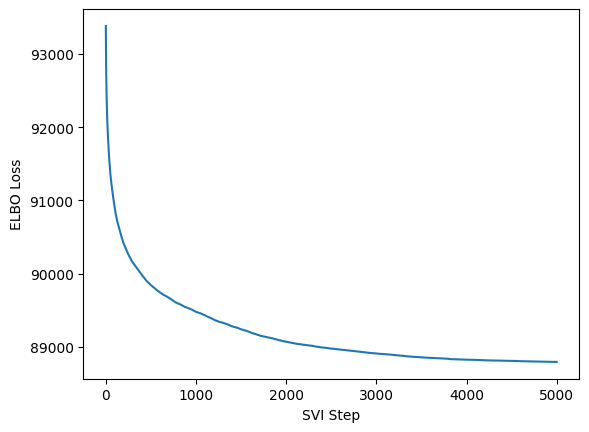

In [226]:
from pyro.infer.autoguide import AutoNormal, AutoDiagonalNormal, AutoContinuous, AutoDelta, AutoMultivariateNormal, AutoLaplaceApproximation, AutoStructured
from pyro.optim import ClippedAdam
from pyro.infer import TraceEnum_ELBO
from pyro.optim import Adam

pyro.clear_param_store()
bnn_cat = BNN_Multi_Layer_SVI(in_dim=16,first_hid_dim=128,sec_hid_dim=128,thir_hid_dim=128,out_dim=2,prior_scale=4,bias_scale=10)
guide = AutoDelta(bnn_cat)
num_steps = 5000

init_lr = 0.001
gamma = 0.01
lrd = gamma ** (1/num_steps)
optim = ClippedAdam({'lr': init_lr, 'lrd': lrd, "betas": (0.95, 0.999)})
# optim = Adam({"lr": 0.01,"betas": (0.95, 0.999)})

svi = SVI(bnn_cat, guide, optim, TraceEnum_ELBO())
losses = []
steps = []

for i in range(num_steps):
    loss = svi.step(x_train,y_train)
    losses.append(loss)
    steps.append(i)
    if i % (num_steps/10) == 0:
        print("[iteration %04d] loss: %.4f" % (i + 1, loss / len(x_train)))

plt.plot(steps,losses)
plt.ylabel("ELBO Loss")
plt.xlabel("SVI Step")
plt.show()

In [227]:
pyro.clear_param_store()
predictive = Predictive(bnn_cat, guide=guide, num_samples=1000, return_sites=["obs","_RETURN"]) # confidence scales inversely w/ num_samples, low num_samp -> high confidence

y_train_1d = [0 if j[0] == 0 else 1 for j in y_train] # [0,1] -> home win -> 0 indicates home win, 1 indicates away
y_test_1d = [0 if j[0] == 0 else 1 for j in y_test]

train_preds = predictive(x_train)['obs'].float().mean(axis=1).float().mean(axis=0)
adj_train_preds = [0 if p[0] < p[1] else 1 for p in train_preds]
print('---TRAINING SET---')
print('TN, FP, FN, TP')
print(confusion_matrix(y_train_1d,adj_train_preds).ravel())
print(classification_report(y_train_1d,adj_train_preds))

pyro.clear_param_store()
test_preds = predictive(x_test)['obs'].float().mean(axis=1).float().mean(axis=0)
adj_test_preds = [0 if p[0] < p[1] else 1 for p in test_preds]
print('---TEST SET---')
print('TN, FP, FN, TP')
print(confusion_matrix(y_test_1d,adj_test_preds).ravel())
print(classification_report(y_test_1d,adj_test_preds))

---TRAINING SET---
TN, FP, FN, TP
[4054 1255 1679 3386]
              precision    recall  f1-score   support

           0       0.71      0.76      0.73      5309
           1       0.73      0.67      0.70      5065

    accuracy                           0.72     10374
   macro avg       0.72      0.72      0.72     10374
weighted avg       0.72      0.72      0.72     10374

---TEST SET---
TN, FP, FN, TP
[360 301 361 292]
              precision    recall  f1-score   support

           0       0.50      0.54      0.52       661
           1       0.49      0.45      0.47       653

    accuracy                           0.50      1314
   macro avg       0.50      0.50      0.49      1314
weighted avg       0.50      0.50      0.50      1314



In [223]:
# features_new = maxabs_scale(np.genfromtxt('../NBA/total/samps_feats/2022-2023_nba_features_inj.csv',delimiter=','))
features_new = np.genfromtxt('../NBA/total/samps_feats/2022-2023_nba_features_inj.csv',delimiter=',')
samples_new = np.genfromtxt('../NBA/total/samps_feats/2022-2023_nba_samples_inj.csv',delimiter=',')
bet_data = np.genfromtxt('../NBA/with_bets/2022-2023_season.csv',delimiter=',')

samples_new_1d = [0 if j[0] == 0 else 1 for j in samples_new]

new_x_tens = torch.FloatTensor(features_new)
new_y_tens = torch.FloatTensor(samples_new)

pyro.clear_param_store()

# new_y_pred = predictive(new_x_tens)['obs'].T.float().mean(axis=2)
new_y_pred = predictive(new_x_tens)['obs'].float().mean(axis=1).float().mean(axis=0)
print('PREDICTIONS ON 2022-2023 DATA (SEEN IN TRAINING)')
print(f'max confidence: {new_y_pred.max():.2f}')

correct,guessed,team_bet,probs,amount,gained = BNN_kelly(new_y_pred,samples_new_1d,bet_data[1:],one_hot=True, diff_thresh=0.05)
print(f'correct: {correct}')
print(f'guessed: {guessed}')
print(f'risked: {sum(amount)}')
print(f'made: {sum(gained)}')
print(f'ROI: {(sum(gained)/sum(amount)):.2f}\n')

# Test on 2023-2024 data
# features_new = maxabs_scale(np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_features_inj.csv',delimiter=','))
features_new = np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_features_inj.csv',delimiter=',')
samples_new = np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_samples_inj.csv',delimiter=',')
bet_data = np.genfromtxt('../NBA/with_bets/2023-2024_season.csv',delimiter=',')

samples_new_1d = [0 if j[0] == 0 else 1 for j in samples_new]

new_x_tens = torch.FloatTensor(features_new)
new_y_tens = torch.FloatTensor(samples_new)

pyro.clear_param_store()

# new_y_pred = predictive(new_x_tens)['obs'].T.float().mean(axis=2)
new_y_pred = predictive(new_x_tens)['obs'].float().mean(axis=1).float().mean(axis=0)
print('PREDICTIONS ON 2023-2024 DATA (UNSEEN)')
print(f'max confidence: {new_y_pred.max():.2f}')

correct,guessed,team_bet,probs,amount,gained = BNN_kelly(new_y_pred,samples_new_1d,bet_data[1:], one_hot=True, diff_thresh=0.05)
print(f'correct: {correct}')
print(f'guessed: {guessed}')
print(f'risked: {sum(amount)}')
print(f'made: {sum(gained)}')
print(f'ROI: {(sum(gained)/sum(amount)):.2f}')

PREDICTIONS ON 2022-2023 DATA (SEEN IN TRAINING)
max confidence: 0.91
correct: 1272
guessed: 1277
risked: 119647.5234375
made: 62617.00390625
ROI: 0.52

PREDICTIONS ON 2023-2024 DATA (UNSEEN)
max confidence: 0.92
correct: 661
guessed: 1279
risked: 113455.3203125
made: -25223.041015625
ROI: -0.22


In [283]:
import pickle

with open('../NBA/on_off_stats/2023-2024_on_off.pkl', 'rb') as f:
    on_off_2023_2024 = pickle.load(f)
with open('../NBA/on_off_stats/2023-2024_team_stats.pkl', 'rb') as f:
    team_stats_2023_2024 = pickle.load(f)
    
nba_szn_2023_2024 = Nba_Season('2023','2024',team_stats=team_stats_2023_2024,team_on_off=on_off_2023_2024)
inj = {'DAL': ['OLIVIER-MAXENCE PROSPER'], 'BOS': []}
home_stats,away_stats = nba_szn_2023_2024.calc_injury_impact(inj, 'BOS', 'DAL')
today = torch.FloatTensor(np.subtract(away_stats,home_stats))

bet_data = np.genfromtxt('test_today_with_bet.csv',delimiter=',')

pyro.clear_param_store()
today_pred = predictive(today.reshape([1,16]))['obs'].float().mean(axis=1).float().mean(axis=0)
print(f'away_weight: {today_pred[0][0]}, home_weight: {today_pred[0][1]}')
print(f'max confidence: {today_pred.max()}')

correct,guessed,team_bet,probs,amount,gained = BNN_kelly(today_pred,samples_new_1d,bet_data[1:], one_hot=True, diff_thresh=-0.5)
print(f'bet on: {team_bet}')
print(f'risked: {amount}')
print(f'made: {sum(gained)}')

away_weight: 0.4625000059604645, home_weight: 0.5375000238418579
max confidence: 0.5375000238418579
bet on: ['Away']
risked: [tensor(14.5136)]
made: -14.513629913330078


In [258]:
today_pred = predictive(today.reshape([1,16]))
print('grug')

grug


In [254]:
# bet_df = correct,guessed,team_bet,probs,amount,gained
bet_dict = {
    'team_bet': team_bet,
    'probs': probs,
    'amount': amount,
    'gained': gained
}
bet_df = pd.DataFrame(bet_dict)
print(bet_df)

     team_bet           probs           amount           gained
0        Home  tensor(0.4600)  tensor(-6.2615)   tensor(3.9135)
1        Away  tensor(0.5650)  tensor(12.0017)   tensor(9.5251)
2        Home  tensor(0.4800)  tensor(-3.2427)   tensor(3.2427)
3        Away  tensor(0.4900)  tensor(-1.6723)   tensor(1.1454)
4        Home  tensor(0.4500)  tensor(-7.4134)   tensor(4.2121)
...       ...             ...              ...              ...
1309     Home  tensor(0.5450)   tensor(6.8437)  tensor(-6.8437)
1310     Away  tensor(0.5250)   tensor(5.0900)  tensor(-5.0900)
1311     Home  tensor(0.5250)   tensor(3.7279)  tensor(-3.7279)
1312     Away  tensor(0.5050)   tensor(1.0000)   tensor(1.0000)
1313     Home  tensor(0.4400)  tensor(-9.3366)   tensor(9.3366)

[1314 rows x 4 columns]


## Using consecutive game stats
Previous training used season totals for prediction, making it unlikely (or unrealistic) that models will perform well on test sets. Data from NBA/conc_feats_samps is different as it uses the teams cumulative statistics up to the day of the game for generating features, and has 14 features instead 16. Additionally, the new samples generated are not categorical by default. First we will use the same BNN structure from above, converting the samples to 1d

In [3]:
from torch.nn import LogSoftmax

class BNN_Multi_Layer_SVI(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, first_hid_dim=5, sec_hid_dim=5, 
                 thir_hid_dim=5, four_hid_dim=5, prior_scale=1., bias_scale=10.):
        
        super().__init__()

        self.activation = nn.Tanh()
        self.layer1 = PyroModule[nn.Linear](in_dim, first_hid_dim)
        self.layer2 = PyroModule[nn.Linear](first_hid_dim, sec_hid_dim)
        self.layer3 = PyroModule[nn.Linear](sec_hid_dim, thir_hid_dim)
        self.layer4 = PyroModule[nn.Linear](thir_hid_dim, four_hid_dim)
        self.out = PyroModule[nn.Linear](four_hid_dim, out_dim)

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([in_dim, first_hid_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., bias_scale).expand([first_hid_dim,]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([first_hid_dim, sec_hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., bias_scale).expand([sec_hid_dim,]).to_event(1))
        self.layer3.weight = PyroSample(dist.Normal(0., prior_scale).expand([sec_hid_dim, thir_hid_dim]).to_event(2))
        self.layer3.bias = PyroSample(dist.Normal(0., bias_scale).expand([thir_hid_dim,]).to_event(1))
        self.layer4.weight = PyroSample(dist.Normal(0., prior_scale).expand([thir_hid_dim, four_hid_dim]).to_event(2))
        self.layer4.bias = PyroSample(dist.Normal(0., bias_scale).expand([four_hid_dim,]).to_event(1))
        self.out.weight = PyroSample(dist.Normal(0., prior_scale).expand([four_hid_dim, out_dim]).to_event(2))
        self.out.bias = PyroSample(dist.Normal(0., bias_scale).expand([out_dim,]).to_event(1)) # output bias term

    def forward(self, x, y=None):
        z1 = self.activation(x @ self.layer1.weight + self.layer1.bias)
        z2 = self.activation(z1 @ self.layer2.weight + self.layer2.bias)
        z3 = self.activation(z2 @ self.layer3.weight + self.layer3.bias)
        z4 = self.activation(z3 @ self.layer4.weight + self.layer4.bias)
        z5 = self.activation(z4 @ self.out.weight + self.out.bias) # output layer 

        y_hat = Softmax(dim=1)(z5)

        with pyro.plate("data"):
            obs = pyro.sample("obs", dist.OneHotCategorical(probs=y_hat).to_event(1), obs=y,
                        infer={"enumerate": "parallel"})

        return y_hat

In [4]:
from sklearn.preprocessing import minmax_scale, maxabs_scale, StandardScaler
features = np.genfromtxt('../NBA/consec/conc_feats_samps/2017-2023_features_stand.csv',delimiter=',')
samples = np.genfromtxt('../NBA/consec/conc_feats_samps/2017-2023_samples_stand_cat.csv',delimiter=',')
feat_test = StandardScaler().fit_transform((np.genfromtxt('../NBA/consec/conc_feats_samps/2023-2024_nba_features_inj.csv',delimiter=',')))
# feat_test = np.genfromtxt('../NBA/consec/conc_feats_samps/2023-2024_nba_features_inj.csv',delimiter=',')
samp_test = np.genfromtxt('../NBA/consec/conc_feats_samps/2023-2024_samples_cat.csv',delimiter=',')

x_train = torch.FloatTensor(features)
x_test = torch.FloatTensor(feat_test)

y_train = torch.Tensor(samples)
y_test = torch.Tensor(samp_test)

[iteration 0001] loss: 2.9226
[iteration 0301] loss: 2.5322
[iteration 0601] loss: 2.4281
[iteration 0901] loss: 2.3628
[iteration 1201] loss: 2.3211
[iteration 1501] loss: 2.2942
[iteration 1801] loss: 2.2780
[iteration 2101] loss: 2.2688
[iteration 2401] loss: 2.2636
[iteration 2701] loss: 2.2603


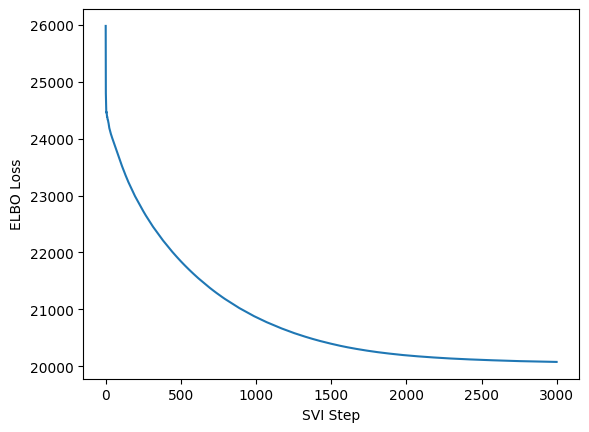

In [44]:
from pyro.infer.autoguide import AutoNormal, AutoDiagonalNormal, AutoContinuous, AutoDelta, AutoMultivariateNormal, AutoLaplaceApproximation, AutoStructured
from pyro.optim import ClippedAdam
from pyro.infer import TraceEnum_ELBO
from pyro.optim import Adam

pyro.clear_param_store()
bnn_cat = BNN_Multi_Layer_SVI(in_dim=14,first_hid_dim=56,sec_hid_dim=112,thir_hid_dim=112,four_hid_dim=56,out_dim=2,prior_scale=0.75,bias_scale=5)
guide = AutoDelta(bnn_cat)
# guide = AutoDiagonalNormal(bnn_cat)
num_steps = 3000

init_lr = 0.0015
gamma = 0.01
lrd = gamma ** (1/num_steps)
optim = ClippedAdam({'lr': init_lr, 'lrd': lrd, "betas": (0.90, 0.999)})
# optim = Adam({"lr": 0.001,"betas": (0.95, 0.999)})

svi = SVI(bnn_cat, guide, optim, TraceEnum_ELBO())
losses = []
steps = []

for i in range(num_steps):
    loss = svi.step(x_train,y_train)
    losses.append(loss)
    steps.append(i)
    if i % (num_steps/10) == 0:
        print("[iteration %04d] loss: %.4f" % (i + 1, loss / len(x_train)))

plt.plot(steps,losses)
plt.ylabel("ELBO Loss")
plt.xlabel("SVI Step")
plt.show()

In [49]:
from pyro.infer import MCMC, NUTS

pyro.clear_param_store()
bnn_cat = BNN_Multi_Layer_SVI(in_dim=14,first_hid_dim=56,sec_hid_dim=112,thir_hid_dim=112,four_hid_dim=56,out_dim=2,prior_scale=0.75,bias_scale=5)
nuts_kernel = NUTS(bnn_cat, jit_compile=True)

# mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=200)
mcmc = MCMC(nuts_kernel, num_samples=100)

mcmc.run(x_train, y_train)

Sample: 100%|██████████| 200/200 [1:34:04, 28.22s/it, step size=2.60e-03, acc. prob=0.921]


In [76]:
from pyro.infer import MCMC, NUTS

pyro.clear_param_store()
bnn_cat = BNN_Multi_Layer_SVI(in_dim=14,first_hid_dim=14,sec_hid_dim=28,thir_hid_dim=28,four_hid_dim=14,out_dim=2,prior_scale=1,bias_scale=5)
nuts_kernel = NUTS(bnn_cat, jit_compile=True)

# mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=200)
mcmc = MCMC(nuts_kernel, num_samples=50)

mcmc.run(x_train, y_train)

Sample: 100%|██████████| 400/400 [1:23:37, 12.54s/it, step size=4.06e-03, acc. prob=0.881]


In [70]:
# get predictions based on posteriors
predictive = Predictive(model=bnn_cat, posterior_samples=mcmc.get_samples(), return_sites=['obs','_RETURN'])

In [71]:
y_train_1d = [0 if j[0] == 0 else 1 for j in y_train] # [0,1] -> home win -> 0 indicates home win, 1 indicates away
y_test_1d = [0 if j[0] == 0 else 1 for j in y_test]

train_preds = predictive(x_train)['_RETURN'].float().mean(axis=0)
adj_train_preds = [0 if p[0] < p[1] else 1 for p in train_preds]
print('---TRAINING SET---')
print('TN, FP, FN, TP')
print(confusion_matrix(y_train_1d,adj_train_preds).ravel())
print(classification_report(y_train_1d,adj_train_preds))

pyro.clear_param_store()
test_preds = predictive(x_test)['_RETURN'].float().mean(axis=0)
adj_test_preds = [0 if p[0] < p[1] else 1 for p in test_preds]
print('---TEST SET---')
print('TN, FP, FN, TP')
print(confusion_matrix(y_test_1d,adj_test_preds).ravel())
print(classification_report(y_test_1d,adj_test_preds))

---TRAINING SET---
TN, FP, FN, TP
[4165  900 1873 1952]
              precision    recall  f1-score   support

           0       0.69      0.82      0.75      5065
           1       0.68      0.51      0.58      3825

    accuracy                           0.69      8890
   macro avg       0.69      0.67      0.67      8890
weighted avg       0.69      0.69      0.68      8890

---TEST SET---
TN, FP, FN, TP
[560 158 310 286]
              precision    recall  f1-score   support

           0       0.64      0.78      0.71       718
           1       0.64      0.48      0.55       596

    accuracy                           0.64      1314
   macro avg       0.64      0.63      0.63      1314
weighted avg       0.64      0.64      0.63      1314



In [74]:
bet_data = np.genfromtxt('../NBA/with_bets/2022-2023_season.csv',delimiter=',')
# bet_train = torch.FloatTensor(np.genfromtxt('../NBA/consec/conc_feats_samps/2022-2023_nba_features_inj.csv',delimiter=','))
# bet_train = torch.FloatTensor(minmax_scale(np.genfromtxt('../NBA/consec/conc_feats_samps/2022-2023_nba_features_inj.csv',delimiter=',')))
bet_train = torch.FloatTensor(StandardScaler().fit_transform((np.genfromtxt('../NBA/consec/conc_feats_samps/2022-2023_nba_features_inj.csv',delimiter=','))))
bet_samps = np.genfromtxt('../NBA/consec/conc_feats_samps/2022-2023_nba_samples_inj.csv',delimiter=',')
bet_samps_1d = [0 if j[0] < j[1] else 1 for j in bet_samps]

pyro.clear_param_store()

new_y_pred = predictive(bet_train)['obs'].float().mean(axis=1).float().mean(axis=0)
# new_y_pred = predictive(bet_train)['_RETURN'].float().mean(axis=0)
print('PREDICTIONS ON 2022-2023 DATA (SEEN IN TRAINING)')
print(f'max confidence: {new_y_pred.max():.2f}')

correct,guessed,team_bet,probs,amount,gained = BNN_kelly(new_y_pred,bet_samps_1d,bet_data[1:],one_hot=True, diff_thresh=0.05)
print(f'correct: {correct}')
print(f'guessed: {guessed}')
print(f'risked: {sum(amount)}')
print(f'made: {sum(gained)}')
print(f'ROI: {(sum(gained)/sum(amount)):.2f}\n')

# Test on 2023-2024 data
bet_data = np.genfromtxt('../NBA/with_bets/2023-2024_season.csv',delimiter=',')

pyro.clear_param_store()

new_y_pred = predictive(x_test)['obs'].float().mean(axis=1).float().mean(axis=0)
# new_y_pred = predictive(x_test)['_RETURN'].float().mean(axis=0)
print('PREDICTIONS ON 2023-2024 DATA (UNSEEN)')
print(f'max confidence: {new_y_pred.max():.2f}')

correct,guessed,team_bet,probs,amount,gained = BNN_kelly(new_y_pred,y_test_1d,bet_data[1:], one_hot=True, diff_thresh=-50.05)
print(f'correct: {correct}')
print(f'guessed: {guessed}')
print(f'risked: {sum(amount)}')
print(f'made: {sum(gained)}')
print(f'ROI: {(sum(gained)/sum(amount)):.2f}')

PREDICTIONS ON 2022-2023 DATA (SEEN IN TRAINING)
max confidence: 0.90
correct: 686
guessed: 1070
risked: 39551.66015625
made: 3483.553466796875
ROI: 0.09

PREDICTIONS ON 2023-2024 DATA (UNSEEN)
max confidence: 0.96
correct: 659
guessed: 1313
risked: 39526.2734375
made: -6355.5283203125
ROI: -0.16


In [75]:
bet_data = np.genfromtxt('../NBA/with_bets/2022-2023_season.csv',delimiter=',')
# bet_train = torch.FloatTensor(np.genfromtxt('../NBA/consec/conc_feats_samps/2022-2023_nba_features_inj.csv',delimiter=','))
# bet_train = torch.FloatTensor(minmax_scale(np.genfromtxt('../NBA/consec/conc_feats_samps/2022-2023_nba_features_inj.csv',delimiter=',')))
bet_train = torch.FloatTensor(StandardScaler().fit_transform((np.genfromtxt('../NBA/consec/conc_feats_samps/2022-2023_nba_features_inj.csv',delimiter=','))))
bet_samps = np.genfromtxt('../NBA/consec/conc_feats_samps/2022-2023_nba_samples_inj.csv',delimiter=',')
bet_samps_1d = [0 if j[0] < j[1] else 1 for j in bet_samps]

pyro.clear_param_store()

# new_y_pred = predictive(bet_train)['obs'].float().mean(axis=1).float().mean(axis=0)
new_y_pred = predictive(bet_train)['_RETURN'].float().mean(axis=0)
print('PREDICTIONS ON 2022-2023 DATA (SEEN IN TRAINING)')
print(f'max confidence: {new_y_pred.max():.2f}')

correct,guessed,team_bet,probs,amount,gained = BNN_kelly(new_y_pred,bet_samps_1d,bet_data[1:],one_hot=True, diff_thresh=0.05)
print(f'correct: {correct}')
print(f'guessed: {guessed}')
print(f'risked: {sum(amount)}')
print(f'made: {sum(gained)}')
print(f'ROI: {(sum(gained)/sum(amount)):.2f}\n')

# Test on 2023-2024 data
bet_data = np.genfromtxt('../NBA/with_bets/2023-2024_season.csv',delimiter=',')

pyro.clear_param_store()

# new_y_pred = predictive(x_test)['obs'].float().mean(axis=1).float().mean(axis=0)
new_y_pred = predictive(x_test)['_RETURN'].float().mean(axis=0)
print('PREDICTIONS ON 2023-2024 DATA (UNSEEN)')
print(f'max confidence: {new_y_pred.max():.2f}')

correct,guessed,team_bet,probs,amount,gained = BNN_kelly(new_y_pred,y_test_1d,bet_data[1:], one_hot=True, diff_thresh=-50.05)
print(f'correct: {correct}')
print(f'guessed: {guessed}')
print(f'risked: {sum(amount)}')
print(f'made: {sum(gained)}')
print(f'ROI: {(sum(gained)/sum(amount)):.2f}')

PREDICTIONS ON 2022-2023 DATA (SEEN IN TRAINING)
max confidence: 0.85
correct: 688
guessed: 1009
risked: 31201.240234375
made: 6047.7021484375
ROI: 0.19

PREDICTIONS ON 2023-2024 DATA (UNSEEN)
max confidence: 0.84
correct: 687
guessed: 1313
risked: 33340.66015625
made: -5032.83984375
ROI: -0.15


In [6]:
pyro.clear_param_store()
predictive = Predictive(bnn_cat, guide=guide, num_samples=500, return_sites=["obs","_RETURN"]) # confidence scales inversely w/ num_samples, low num_samp -> high confidence

y_train_1d = [0 if j[0] == 0 else 1 for j in y_train] # [0,1] -> home win -> 0 indicates home win, 1 indicates away
y_test_1d = [0 if j[0] == 0 else 1 for j in y_test]

train_preds = predictive(x_train)['_RETURN'].float().mean(axis=0)
adj_train_preds = [0 if p[0] < p[1] else 1 for p in train_preds]
print('---TRAINING SET---')
print('TN, FP, FN, TP')
print(confusion_matrix(y_train_1d,adj_train_preds).ravel())
print(classification_report(y_train_1d,adj_train_preds))

pyro.clear_param_store()
test_preds = predictive(x_test)['_RETURN'].float().mean(axis=0)
adj_test_preds = [0 if p[0] < p[1] else 1 for p in test_preds]
print('---TEST SET---')
print('TN, FP, FN, TP')
print(confusion_matrix(y_test_1d,adj_test_preds).ravel())
print(classification_report(y_test_1d,adj_test_preds))

---TRAINING SET---
TN, FP, FN, TP
[4098  967 1316 2509]
              precision    recall  f1-score   support

           0       0.76      0.81      0.78      5065
           1       0.72      0.66      0.69      3825

    accuracy                           0.74      8890
   macro avg       0.74      0.73      0.73      8890
weighted avg       0.74      0.74      0.74      8890

---TEST SET---
TN, FP, FN, TP
[545 173 333 263]
              precision    recall  f1-score   support

           0       0.62      0.76      0.68       718
           1       0.60      0.44      0.51       596

    accuracy                           0.61      1314
   macro avg       0.61      0.60      0.60      1314
weighted avg       0.61      0.61      0.60      1314



In [45]:
pyro.clear_param_store()
predictive = Predictive(bnn_cat, guide=guide, num_samples=500, return_sites=["obs","_RETURN"]) # confidence scales inversely w/ num_samples, low num_samp -> high confidence

y_train_1d = [0 if j[0] == 0 else 1 for j in y_train] # [0,1] -> home win -> 0 indicates home win, 1 indicates away
y_test_1d = [0 if j[0] == 0 else 1 for j in y_test]

train_preds = predictive(x_train)['obs'].float().mean(axis=1).float().mean(axis=0)
adj_train_preds = [0 if p[0] < p[1] else 1 for p in train_preds]
print('---TRAINING SET---')
print('TN, FP, FN, TP')
print(confusion_matrix(y_train_1d,adj_train_preds).ravel())
print(classification_report(y_train_1d,adj_train_preds))

pyro.clear_param_store()
test_preds = predictive(x_test)['obs'].float().mean(axis=1).float().mean(axis=0)
adj_test_preds = [0 if p[0] < p[1] else 1 for p in test_preds]
print('---TEST SET---')
print('TN, FP, FN, TP')
print(confusion_matrix(y_test_1d,adj_test_preds).ravel())
print(classification_report(y_test_1d,adj_test_preds))

---TRAINING SET---
TN, FP, FN, TP
[4989   76  160 3665]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      5065
           1       0.98      0.96      0.97      3825

    accuracy                           0.97      8890
   macro avg       0.97      0.97      0.97      8890
weighted avg       0.97      0.97      0.97      8890

---TEST SET---
TN, FP, FN, TP
[469 249 307 289]
              precision    recall  f1-score   support

           0       0.60      0.65      0.63       718
           1       0.54      0.48      0.51       596

    accuracy                           0.58      1314
   macro avg       0.57      0.57      0.57      1314
weighted avg       0.57      0.58      0.57      1314



In [39]:
pyro.clear_param_store()
predictive = Predictive(bnn_cat, guide=guide, num_samples=2000, return_sites=["obs","_RETURN"]) # confidence scales inversely w/ num_samples, low num_samp -> high confidence

In [46]:
bet_data = np.genfromtxt('../NBA/with_bets/2022-2023_season.csv',delimiter=',')
# bet_train = torch.FloatTensor(np.genfromtxt('../NBA/consec/conc_feats_samps/2022-2023_nba_features_inj.csv',delimiter=','))
# bet_train = torch.FloatTensor(minmax_scale(np.genfromtxt('../NBA/consec/conc_feats_samps/2022-2023_nba_features_inj.csv',delimiter=',')))
bet_train = torch.FloatTensor(StandardScaler().fit_transform((np.genfromtxt('../NBA/consec/conc_feats_samps/2022-2023_nba_features_inj.csv',delimiter=','))))
bet_samps = np.genfromtxt('../NBA/consec/conc_feats_samps/2022-2023_nba_samples_inj.csv',delimiter=',')
bet_samps_1d = [0 if j[0] < j[1] else 1 for j in bet_samps]

pyro.clear_param_store()

new_y_pred = predictive(bet_train)['obs'].float().mean(axis=1).float().mean(axis=0)
# new_y_pred = predictive(bet_train)['_RETURN'].float().mean(axis=0)
print('PREDICTIONS ON 2022-2023 DATA (SEEN IN TRAINING)')
print(f'max confidence: {new_y_pred.max():.2f}')

correct,guessed,team_bet,probs,amount,gained = BNN_kelly(new_y_pred,bet_samps_1d,bet_data[1:],one_hot=True, diff_thresh=0.05)
print(f'correct: {correct}')
print(f'guessed: {guessed}')
print(f'risked: {sum(amount)}')
print(f'made: {sum(gained)}')
print(f'ROI: {(sum(gained)/sum(amount)):.2f}\n')

# # Test on 2023-2024 data
bet_data = np.genfromtxt('../NBA/with_bets/2023-2024_season.csv',delimiter=',')

pyro.clear_param_store()

new_y_pred = predictive(x_test)['obs'].float().mean(axis=1).float().mean(axis=0)
# new_y_pred = predictive(x_test)['_RETURN'].float().mean(axis=0)
print('PREDICTIONS ON 2023-2024 DATA (UNSEEN)')
print(f'max confidence: {new_y_pred.max():.2f}')

correct,guessed,team_bet,probs,amount,gained = BNN_kelly(new_y_pred,y_test_1d,bet_data[1:], one_hot=True, diff_thresh=-50.05)
print(f'correct: {correct}')
print(f'guessed: {guessed}')
print(f'risked: {sum(amount)}')
print(f'made: {sum(gained)}')
print(f'ROI: {(sum(gained)/sum(amount)):.2f}')

PREDICTIONS ON 2022-2023 DATA (SEEN IN TRAINING)
max confidence: 0.93
correct: 1241
guessed: 1273
risked: 116853.859375
made: 56452.7109375
ROI: 0.48

PREDICTIONS ON 2023-2024 DATA (UNSEEN)
max confidence: 0.92
correct: 745
guessed: 1313
risked: 109176.2734375
made: -18509.009765625
ROI: -0.17


In [73]:
bet_data = np.genfromtxt('../NBA/with_bets/2022-2023_season.csv',delimiter=',')
# bet_train = torch.FloatTensor(np.genfromtxt('../NBA/consec/conc_feats_samps/2022-2023_nba_features_inj.csv',delimiter=','))
# bet_train = torch.FloatTensor(minmax_scale(np.genfromtxt('../NBA/consec/conc_feats_samps/2022-2023_nba_features_inj.csv',delimiter=',')))
bet_train = torch.FloatTensor(StandardScaler().fit_transform((np.genfromtxt('../NBA/consec/conc_feats_samps/2022-2023_nba_features_inj.csv',delimiter=','))))
bet_samps = np.genfromtxt('../NBA/consec/conc_feats_samps/2022-2023_nba_samples_inj.csv',delimiter=',')
bet_samps_1d = [0 if j[0] < j[1] else 1 for j in bet_samps]

pyro.clear_param_store()

# new_y_pred = predictive(bet_train)['obs'].float().mean(axis=1).float().mean(axis=0)
new_y_pred = predictive(bet_train)['_RETURN'].float().mean(axis=0)
print('PREDICTIONS ON 2022-2023 DATA (SEEN IN TRAINING)')
print(f'max confidence: {new_y_pred.max():.2f}')

correct,guessed,team_bet,probs,amount,gained = BNN_kelly(new_y_pred,bet_samps_1d,bet_data[1:],one_hot=True, diff_thresh=0.05)
print(f'correct: {correct}')
print(f'guessed: {guessed}')
print(f'risked: {sum(amount)}')
print(f'made: {sum(gained)}')
print(f'ROI: {(sum(gained)/sum(amount)):.2f}\n')

# Test on 2023-2024 data
bet_data = np.genfromtxt('../NBA/with_bets/2023-2024_season.csv',delimiter=',')

pyro.clear_param_store()

# new_y_pred = predictive(x_test)['obs'].float().mean(axis=1).float().mean(axis=0)
new_y_pred = predictive(x_test)['_RETURN'].float().mean(axis=0)
print('PREDICTIONS ON 2023-2024 DATA (UNSEEN)')
print(f'max confidence: {new_y_pred.max():.2f}')

correct,guessed,team_bet,probs,amount,gained = BNN_kelly(new_y_pred,y_test_1d,bet_data[1:], one_hot=True, diff_thresh=0.05)
print(f'correct: {correct}')
print(f'guessed: {guessed}')
print(f'risked: {sum(amount)}')
print(f'made: {sum(gained)}')
print(f'ROI: {(sum(gained)/sum(amount)):.2f}')

PREDICTIONS ON 2022-2023 DATA (SEEN IN TRAINING)
max confidence: 0.85
correct: 688
guessed: 1009
risked: 31201.240234375
made: 6047.7021484375
ROI: 0.19

PREDICTIONS ON 2023-2024 DATA (UNSEEN)
max confidence: 0.84
correct: 536
guessed: 1031
risked: 31616.48828125
made: -5193.66748046875
ROI: -0.16


## Trying different normalization technique
Improving quality of data could be useful, we will explore the performance of a simple BNN on unnormalized, minmax norm, maxabs norm

### Unnormalized
First, we will construct a new unnormalized features file from 2014/2015 to 2022/2023

In [4]:
from sklearn.preprocessing import minmax_scale, maxabs_scale
features = []
feat_minmax = []
feat_maxabs = []
samples = []
start = 2014

while start < 2023:
    if start == 2018: # this year is missing and wont populate thru scraper!!
        start += 1
        continue

    curr_feats = np.genfromtxt('../NBA/total/samps_feats/{start}-{end}_nba_features_inj.csv'.format(start=start,end=start+1),delimiter=',')
    curr_samps = np.genfromtxt('../NBA/total/samps_feats/{start}-{end}_nba_samples_inj.csv'.format(start=start,end=start+1),delimiter=',')
    feat_minmax.extend(minmax_scale(curr_feats))
    feat_maxabs.extend(maxabs_scale(curr_feats))
    features.extend(curr_feats)
    samples.extend(curr_samps)
    start += 1


np.savetxt('../NBA/total/samps_feats/2015-2023_nba_features_unnorm.csv', features, delimiter=',')
np.savetxt('../NBA/total/samps_feats/2015-2023_nba_samples.csv', samples, delimiter=',')
np.savetxt('../NBA/total/samps_feats/2015-2023_nba_features_minmax.csv', features, delimiter=',')
np.savetxt('../NBA/total/samps_feats/2015-2023_nba_features_maxabs.csv', features, delimiter=',')

In [5]:
feat_test = np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_features_inj.csv',delimiter=',') # unnormalized
samp_test = np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_samples_inj.csv',delimiter=',')

x_train = torch.FloatTensor(features)
x_test = torch.FloatTensor(feat_test)
y_train = torch.FloatTensor(samples)
y_test = torch.FloatTensor(samp_test)

C:\Users\andre\AppData\Local\Temp\ipykernel_15840\2636246682.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  x_train = torch.FloatTensor(features)


In [6]:
from pyro.infer import MCMC, NUTS

x_train = torch.FloatTensor(feat_maxabs)
x_test = torch.FloatTensor(maxabs_scale(feat_test))
y_train = torch.FloatTensor(samples)
y_test = torch.FloatTensor(samp_test)

model = BNN(in_dim=16,hid_dim=16,out_dim=2)

pyro.set_rng_seed(1)

# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(model, jit_compile=False)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get 50 posterior samples
mcmc = MCMC(nuts_kernel, num_samples=50)

mcmc.run(x_train, y_train.T)

Sample: 100%|██████████| 100/100 [01:35,  1.05it/s, step size=4.07e-02, acc. prob=0.788]


In [7]:
# get predictions based on posteriors
predictive = Predictive(model=model, posterior_samples=mcmc.get_samples(), return_sites=['obs','_RETURN'])

train_preds = predictive(x_train)['obs'].T.float().mean(axis=1)
test_preds = predictive(x_test)['obs'].T.float().mean(axis=1)

adj_train_preds = [0 if p < 0.5 else 1 for p in train_preds]
adj_test_preds = [0 if p < 0.5 else 1 for p in test_preds]
y_train_1d = [0 if j[0] == 0 else 1 for j in y_train] # [0,1] -> [away,home] -> 0 indicates home win, 1 indicates away
y_test_1d = [0 if j[0] == 0 else 1 for j in y_test]

print('---TRAINING SET---')
print('TN, FP, FN, TP')
print(confusion_matrix(y_train_1d,adj_train_preds).ravel())
print(classification_report(y_train_1d,adj_train_preds))
print('---TEST SET---')
print('TN, FP, FN, TP')
print(confusion_matrix(y_test_1d,adj_test_preds).ravel())
print(classification_report(y_test_1d,adj_test_preds))

---TRAINING SET---
TN, FP, FN, TP
[2384 2925 2191 2874]
              precision    recall  f1-score   support

           0       0.52      0.45      0.48      5309
           1       0.50      0.57      0.53      5065

    accuracy                           0.51     10374
   macro avg       0.51      0.51      0.51     10374
weighted avg       0.51      0.51      0.51     10374

---TEST SET---
TN, FP, FN, TP
[296 365 267 386]
              precision    recall  f1-score   support

           0       0.53      0.45      0.48       661
           1       0.51      0.59      0.55       653

    accuracy                           0.52      1314
   macro avg       0.52      0.52      0.52      1314
weighted avg       0.52      0.52      0.52      1314



In [8]:
# Get 2022-2023 game data and betting information
features_new = maxabs_scale(np.genfromtxt('../NBA/total/samps_feats/2022-2023_nba_features_inj.csv',delimiter=','))
samples_new = np.genfromtxt('../NBA/total/samps_feats/2022-2023_nba_samples_inj.csv',delimiter=',')
bet_data = np.genfromtxt('../NBA/with_bets/2022-2023_season.csv',delimiter=',')

samples_new_1d = [0 if j[0] == 0 else 1 for j in samples_new]

new_x_tens = torch.FloatTensor(features_new)
new_y_tens = torch.FloatTensor(samples_new)

new_predictive = Predictive(model=model, posterior_samples=mcmc.get_samples(),return_sites=("obs","_RETURN"))
new_y_pred = new_predictive(new_x_tens)['obs'].T.float().mean(axis=1)

correct,guessed,team_bet,probs,amount,gained = BNN_kelly(new_y_pred,samples_new_1d,bet_data[1:])
print(correct)
print(guessed)
print(sum(gained))

# Test on 2023-2024 data
features_new = maxabs_scale(np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_features_inj.csv',delimiter=','))
samples_new = np.genfromtxt('../NBA/total/samps_feats/2023-2024_nba_samples_inj.csv',delimiter=',')
bet_data = np.genfromtxt('../NBA/with_bets/2023-2024_season.csv',delimiter=',')

samples_new_1d = [0 if j[0] == 0 else 1 for j in samples_new]

new_x_tens = torch.FloatTensor(features_new)
new_y_tens = torch.FloatTensor(samples_new)

new_predictive = Predictive(model=model, posterior_samples=mcmc.get_samples(),return_sites=("obs","_RETURN"))
new_y_pred = new_predictive(new_x_tens)['obs'].T.float().mean(axis=1)

correct,guessed,team_bet,probs,amount,gained = BNN_kelly(new_y_pred,samples_new_1d,bet_data[1:])
print(correct)
print(guessed)
print(sum(gained))

40
106
tensor(-746.6345)
49
118
tensor(-704.2104)
